# Weighted K-Means Clustering

In this exercise we will simulate finding good locations for production plants of a company in order to minimize its logistical costs. In particular, we would like to place production plants near customers so as to reduce shipping costs and delivery time.

We assume that the probability of someone being a customer is independent of its geographical location and that the overall cost of delivering products to customers is proportional to the squared Euclidean distance to the closest production plant. Under these assumptions, the K-Means algorithm is an appropriate method to find a good set of locations. Indeed, K-Means finds a spatial clustering of potential customers and the centroid of each cluster can be chosen to be the location of the plant.

Because there are potentially millions of customers, and that it is not scalable to model each customer as a data point in the K-Means procedure, we consider instead as many points as there are geographical locations, and assign to each geographical location a weight $w_i$ corresponding to the number of inhabitants at that location. The resulting problem becomes a weighted version of K-Means where we seek to minimize the objective:

$$
J(c_1,\dots,c_K) = \frac{\sum_{i} w_i \min_k ||x_i-c_k||^2}{\sum_{i} w_i},
$$

where $c_k$ is the $k$th centroid, and $w_i$ is the weight of each geographical coordinate $x_i$. In order to minimize this cost function, we iteratively perform the following EM computations:

* **Expectation step:** Compute the set of points associated to each centroid:
$$
\forall~1 \leq k \leq K: \quad \mathcal{C}(k) \leftarrow \Big\{ i ~:~ k = \mathrm{arg}\min_k \| x_i - c_k \|^2 \Big\}
$$


* **Minimization step:** Recompute the centroid as a the (weighted) mean of the associated data points:
$$
\forall~1 \leq k \leq K: \quad c_k \leftarrow \frac{\sum_{i \in \mathcal{C}(k)} w_i \cdot x_i}{\sum_{i \in \mathcal{C}(k)} w_i}
$$


until the objective $J(c_1,\dots,c_K)$ has converged.


## Getting started

In this exercise we will use data from http://sedac.ciesin.columbia.edu/, that we store in the files `data.mat` as part of the zip archive. The data contains for each geographical coordinates (latitude and longitude), the number of inhabitants and the corresponding country. Several variables and methods are provided in the file `utils.py`:


*  **`utils.population`** A 2D array with the number of inhabitants at each latitude/longitude.


*  **`utils.plot(latitudes,longitudes)`** Plot a list of centroids given as geographical coordinates in overlay to the population density map.

The code below plots three factories (white squares) with geographical coordinates (60,80),
(60,90),(60,100) given as input.

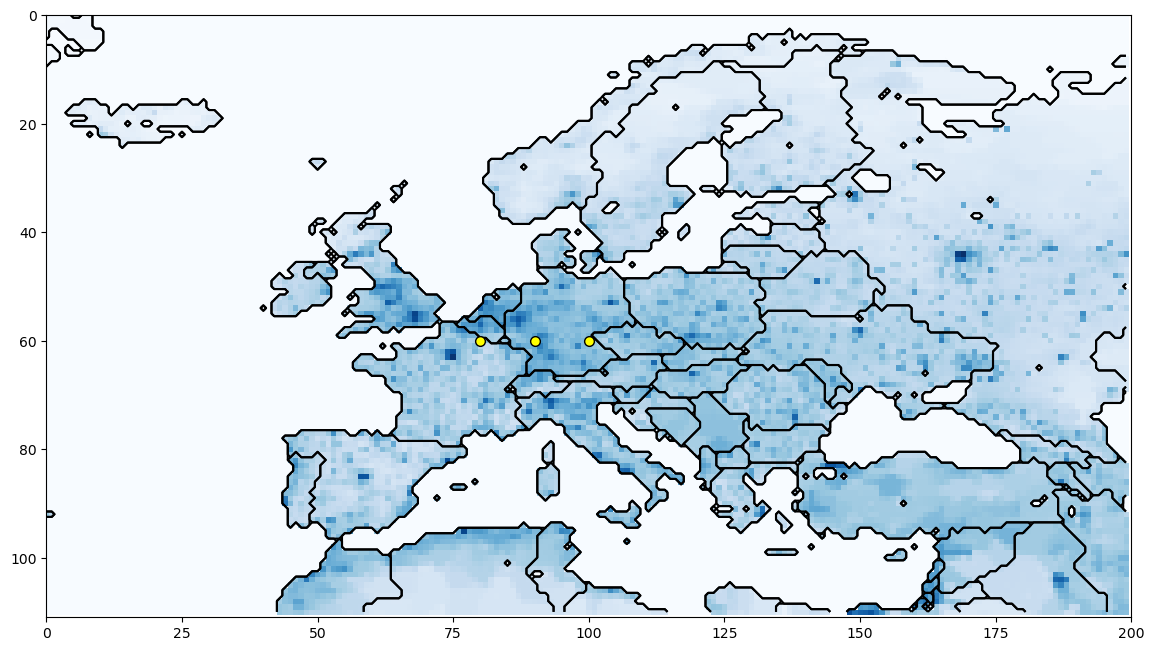

In [1]:
import utils, numpy
%matplotlib inline
utils.plot([60,60,60],[80,90,100])

Also, to get a dataset of geographical coordinates associated to the image given as an array, we can use:

In [2]:
x,y = numpy.indices(utils.population.shape) #(111, 200) (111, 200)
locations = numpy.array([x.flatten(),y.flatten()]).T # (22200, 2)


## Initializing Weighted K-Means (25 P)

Because K-means has a non-convex objective, choosing a good initial set of centroids is important. Centroids are drawn from from the following discrete probability distribution:

$$
P(x,y) = \frac1Z \cdot \text{population}(x,y)
$$

where $Z$ is a normalization constant. Furthermore, to avoid identical centroids, we add a small Gaussian noise to the location of centroids, with standard deviation $0.01$.

In [3]:
print(utils.population.shape)#(111, 200)



(111, 200)


**Task:**

* **Implement the initialization procedure above.**

In [4]:
def initialize(K,population):
    # YOUR CODE HERE
    #import solutions
    #centroids = solutions.initialize(K, population)
    P = population.flatten() / population.flatten().sum()
    #print(P.shape)#(22200,)
    sampled_indices = numpy.random.choice(P.size, size=K, p=P)
    #print(sampled_indices.shape)#(200,)
    
    lat_dim, lon_dim = population.shape  #(111, 200)
    lat = sampled_indices // lon_dim
    lon = sampled_indices % lon_dim
    
    centroids = numpy.column_stack((lat,lon))
    #centroids = population.flatten()[sampled_indices]
    
    centroids = centroids + numpy.random.normal(0, 0.01, centroids.shape)
    
    #print(centroids.shape)
    return centroids #(K,2)
    # --------------


The following code runs the initialization procedure for K=200 clusters and visualizes the centroids obtained with the initialization procedure using `utils.plot`.

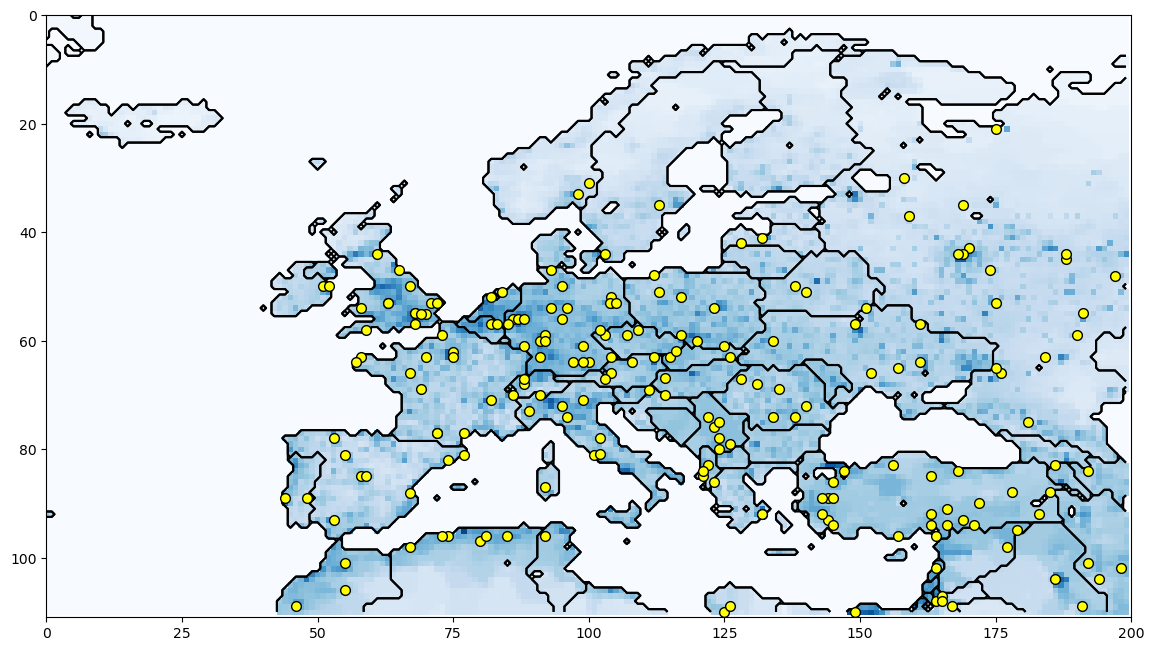

In [5]:
centroids_init = initialize(200, utils.population)
utils.plot(centroids_init[:,0], centroids_init[:,1])

## Implementing Weighted K-Means (75 P)

**Task:**


* **Implement the weighted K-Means algorithm. Your algorithm should run for `nbit` iterations and print the value of the objective after training. If `verbose`, it should also print the value of the objective at each iteration.**

In [6]:
def wkmeans(centroids, points, weights, verbose, nbit):
    # YOUR CODE HERE
    #import solutions
    #centroids = solutions.wkmeans(centroids, points, weights, verbose, nbit)
    
    #print(centroids.shape,points.shape,weights.shape)
    #(200, 2) (22200, 2) (22200,)
    #centroids:(K, d)
    #points: (N, d)
    #weights: (N,)
    
    K = centroids.shape[0]
    
    for it in range(nbit):
        
        J = 0
        
        dist = (points[:,None,:] - centroids[None,:,:])  ** 2
        dist = dist.sum(axis = 2)#(N,K)
        #print(dist.shape) #(22200, 200)
        
        nearest_centrod = numpy.argmin(dist,axis = 1)#(N,)
        
        for i in range(K):
            
            if weights[(nearest_centrod == i)].sum(axis=0) != 0:
                centroids[i] = ( points[(nearest_centrod == i)] * weights[(nearest_centrod == i), None] ).sum(axis=0)
                #                (m,d)                             (m,d)
                centroids[i] = centroids[i] / weights[(nearest_centrod == i)].sum(axis = 0)
            else:
                continue
            
            dist_i_cluster = (points[(nearest_centrod == i)] - centroids[i])  ** 2
            #   (m,d)                (m,d)                          (1,d)
            #print(dist_i_cluster.shape)#(47, 2)
            J += (dist_i_cluster * weights[(nearest_centrod == i),None]).sum()
            #     (m,d)                (m,1)

        J = J / weights.sum() 
        
        if verbose or it +1 == nbit:
            print(f'it:{it + 1} J:{J:.2f}')
    
    
    return centroids
    # --------------

The following code runs the weighted k-means on this data, and displays the final centroids.

it:1 J:11.71
it:2 J:9.72
it:3 J:8.82
it:4 J:8.08
it:5 J:7.85
it:6 J:7.74
it:7 J:7.52
it:8 J:7.36
it:9 J:7.30
it:10 J:7.26
it:11 J:7.22
it:12 J:7.19
it:13 J:7.18
it:14 J:7.16
it:15 J:7.16
it:16 J:7.15
it:17 J:7.15
it:18 J:7.15
it:19 J:7.15
it:20 J:7.15
it:21 J:7.15
it:22 J:7.14
it:23 J:7.14
it:24 J:7.14
it:25 J:7.14
it:26 J:7.14
it:27 J:7.14
it:28 J:7.14
it:29 J:7.14
it:30 J:7.14
it:31 J:7.14
it:32 J:7.14
it:33 J:7.14
it:34 J:7.14
it:35 J:7.14
it:36 J:7.14
it:37 J:7.14
it:38 J:7.14
it:39 J:7.14
it:40 J:7.14
it:41 J:7.14
it:42 J:7.14
it:43 J:7.14
it:44 J:7.14
it:45 J:7.14
it:46 J:7.14
it:47 J:7.14
it:48 J:7.14
it:49 J:7.14
it:50 J:7.14


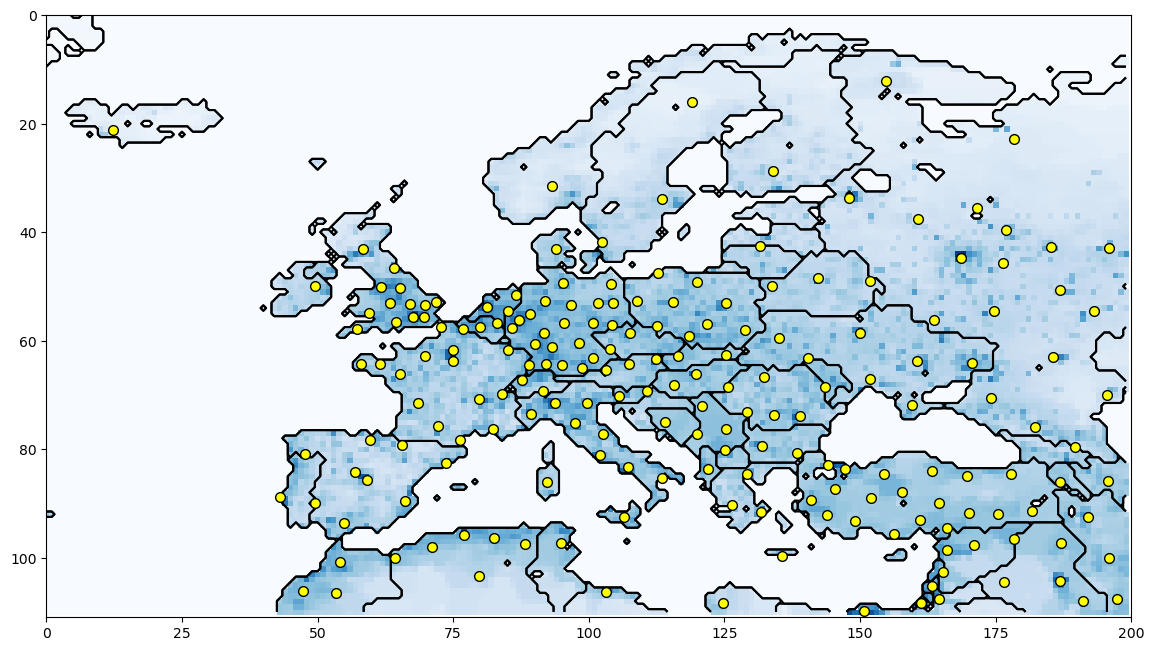

In [7]:
weights   = utils.population.flatten()*1.0

centroids = wkmeans(centroids_init, locations, weights, True, 50)

utils.plot(centroids[:,0], centroids[:,1])

Observe that the k-means algorithm is non-convex, and arrives in local optima of different quality depending on the initialization:

In [8]:
for i in range(5):
    wkmeans(initialize(200, utils.population), locations, weights, False, 50)

it:50 J:6.72
it:50 J:6.49
it:50 J:6.49
it:50 J:7.71
it:50 J:6.99
